## Analyze StrainGE output in Python

Now that we have run StrainGST and StrainGR (including the compare step), how do we analyze the outputs? This page uses Python and its commonly used data science stack (NumPy, SciPy, Pandas and matplotlib+seaborn) to parse the data, plot the relative abundances of strains over time, and generate an ACNI/gap similarity plot.

### Download data

We download an archive containing StrainGE outputs part of the vignette described in the paper on the persistence of an *E. coli* strain in the gut of a woman with recurrent urinary tract infections. The extracted data is organized in a `straingst` and `straingr` folder.

In [2]:
!curl --output umb_data.tar.gz https://raw.githubusercontent.com/broadinstitute/strainge-paper/master/umb/umb_data.tar.gz
!tar -xzvf umb_data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12196  100 12196    0     0  42347      0 --:--:-- --:--:-- --:--:-- 42347
x straingst/UMB11_01.tsv
x straingst/UMB11_02.tsv
x straingst/UMB11_03.1.tsv
x straingst/UMB11_03.tsv
x straingst/UMB11_04.1.tsv
x straingst/UMB11_04.tsv
x straingst/UMB11_05.tsv
x straingst/UMB11_06.tsv
x straingst/UMB11_07.tsv
x straingst/UMB11_08.tsv
x straingst/UMB11_11.tsv
x straingst/UMB11_12.tsv
x straingr/UMB11_01.tsv
x straingr/UMB11_02.tsv
x straingr/UMB11_03.1.tsv
x straingr/UMB11_03.tsv
x straingr/UMB11_04.1.tsv
x straingr/UMB11_04.tsv
x straingr/UMB11_05.tsv
x straingr/UMB11_06.tsv
x straingr/UMB11_07.tsv
x straingr/UMB11_08.tsv
x straingr/UMB11_11.tsv
x straingr/UMB11_12.tsv
x straingr/compare.summary.chrom.txt


### Import required modules


In [3]:
from pathlib import Path

import numpy
import pandas
import matplotlib.pyplot as plt
from IPython.display import display


### StrainGST

#### Read StrainGST outputs and combine it in a DataFrame

The TSV files written by StrainGST contain both sample statistics (the first two lines), and statistics for each identified strain (see [StrainGST](straingst.md) page). In this tutorial, we are mainly interested in the identified strains. In the code below, when calling `pandas.read_csv`, we give the argument `skiprows=2` to skip the sample statistics.


In [16]:
STRAINGST_DIR = Path("straingst/")

df_list = []
sample_names = []
for f in STRAINGST_DIR.glob("*.tsv"):
    sample_name = f.stem
    df = pandas.read_csv(f, sep='\t', comment='#', skiprows=2, index_col=1)

    df_list.append(df)
    sample_names.append(sample_name)


# Combine all StrainGST results from each sample into a single DataFrame.
straingst_df = pandas.concat(df_list, keys=sample_names, names=["sample"])

sample_names = list(sorted(sample_names, key=lambda e: float(e.replace("UMB11_", ""))))
straingst_df.sort_index()

i gkmers ikmers  \
sample     strain                                                            
UMB11_01   Esch_coli_NGF1                                  0  49631  49622   
UMB11_02   Esch_coli_NGF1                                  0  49631  49623   
UMB11_03   Esch_coli_1190                                  0  48261  48249   
UMB11_03.1 Esch_coli_1190                                  0  48261  48254   
UMB11_04.1 Esch_coli_1190                                  0  48261  48250   
UMB11_05   Esch_coli_1190                                  0  48261  48248   
UMB11_06   Esch_coli_1190                                  1  48261  21600   
           Esch_coli_H3                                    0  45610  45560   
UMB11_07   Esch_coli_1190                                  0  48261  48237   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  1  47727  21265   
UMB11_08   Esch_coli_1190                                  0  48261  48248   
UMB11_11   Esch_coli_1190                                  0  48261  48248   
UMB11_12   Esch_coli_1190                                  0  48261  48235   
           Esch_coli_26561                                 1  46249  19738   

                                                          skmers    cov  \
sample     strain                                                         
UMB11_01   Esch_coli_NGF1                                  50090  0.985   
UMB11_02   Esch_coli_NGF1                                   5358  0.103   
UMB11_03   Esch_coli_1190                                  37144  0.711   
UMB11_03.1 Esch_coli_1190                                  31201  0.595   
UMB11_04.1 Esch_coli_1190                                  19042  0.362   
UMB11_05   Esch_coli_1190                                  40411  0.775   
UMB11_06   Esch_coli_1190                                  30714  0.794   
           Esch_coli_H3                                    74449  0.960   
UMB11_07   Esch_coli_1190                                  58276  0.854   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  17074  0.441   
UMB11_08   Esch_coli_1190                                  31599  0.592   
UMB11_11   Esch_coli_1190                                  49462  0.920   
UMB11_12   Esch_coli_1190                                  66509  0.941   
           Esch_coli_26561                                 21112  0.853   

                                                              kcov     gcov  \
sample     strain                                                             
UMB11_01   Esch_coli_NGF1                                    7.009    6.831   
UMB11_02   Esch_coli_NGF1                                    1.546    0.158   
UMB11_03   Esch_coli_1190                                    2.814    1.975   
UMB11_03.1 Esch_coli_1190                                    2.152    1.264   
UMB11_04.1 Esch_coli_1190                                    1.870    0.668   
UMB11_05   Esch_coli_1190                                    2.741    2.097   
UMB11_06   Esch_coli_1190                                    7.102    5.565   
           Esch_coli_H3                                    114.343  109.038   
UMB11_07   Esch_coli_1190                                    4.557    3.846   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8    2.588    1.077   
UMB11_08   Esch_coli_1190                                    2.243    1.309   
UMB11_11   Esch_coli_1190                                    6.107    5.545   
UMB11_12   Esch_coli_1190                                    9.061    8.431   
           Esch_coli_26561                                   4.773    3.983   

                                                            acct   even  \
sample     strain                                                         
UMB11_01   Esch_coli_NGF1                                  0.980  0.987   
UMB11_02   Esch_coli_NGF1                                  0.932  0.707   
UMB11_03   Esch_coli_1190                   

#### Plot relative abundances


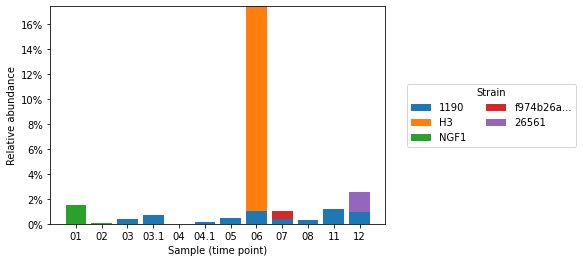

In [5]:
plt.figure(figsize=(6, 4))

strain_order = ['Esch_coli_1190', 'Esch_coli_H3', 'Esch_coli_NGF1', 'Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8', "Esch_coli_26561"]
strain_labels = ['1190', 'H3', 'NGF1', 'f974b26a...', "26561"]
xlabels = [s.replace("UMB11_", "") for s in sample_names]

x = numpy.arange(len(sample_names))
bottom = numpy.zeros((len(sample_names),))
for ref, label in zip(strain_order, strain_labels):
    # Create an array with all relative abundances for the current reference in each sample. If not available, set to zero.
    rel_abun = numpy.array([
        straingst_df.loc[(sample, ref), 'rapct'] if (sample, ref) in straingst_df.index else 0.0
        for sample in sample_names
    ])

    plt.bar(x, rel_abun, bottom=bottom, tick_label=xlabels, label=label, width=0.8)
    bottom += rel_abun

plt.xlabel("Sample (time point)")
plt.ylabel("Relative abundance")
plt.gca().yaxis.set_major_formatter("{x:g}%")
plt.legend(title="Strain", loc="center left", bbox_to_anchor=(1.05, 0.5), ncol=2)

plt.show()

### StrainGR

#### Load `call` data in a DataFrame

To load StrainGR outputs, we use a similar approach as descried above. In this case, the StrainGR TSV files can be directly loaded with pandas without `skiprows`.

One thing to note, StrainGR outputs metrics for every contig in the concatenated reference used for alignment. The output file thus contains metrics for **contigs from strains that were not predicted to be present by StrainGST**. We use the presence/absence predictions of StrainGST as our "truth" and remove the contigs from strains that weren't present.

We apply a few other filters, including removing plasmid contigs, and contigs with less coverage than 0.5x.

In [28]:
STRAINGR_DIR = Path("straingr/")

df_list = []
sample_names = []
for f in STRAINGR_DIR.glob("*.tsv"):
    df = pandas.read_csv(f, sep='\t', index_col=0)
    df = df.drop(index='TOTAL')  # Remove TOTAL statistics

    df_list.append(df)
    sample_names.append(f.stem)

straingr_df = pandas.concat(df_list, keys=sample_names, names=["sample"])
straingr_df['straingst_present'] = straingr_df.index.map(lambda ix: ix in straingst_df.index)
straingr_df['is_plasmid'] = straingr_df['length'] < 4e6
straingr_df['enough_cov'] = straingr_df['coverage'] > 0.5

# Filter and re-index
straingr_df = straingr_df[straingr_df['straingst_present'] & ~straingr_df['is_plasmid'] & straingr_df['enough_cov']].reset_index().set_index(['sample', 'ref'])
straingr_df

name  \
sample     ref                                                             
UMB11_11   Esch_coli_1190                                  NZ_CP023386.1   
UMB11_06   Esch_coli_H3                                    NZ_CP010167.1   
           Esch_coli_1190                                  NZ_CP023386.1   
UMB11_07   Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  NZ_LR536430.1   
           Esch_coli_1190                                  NZ_CP023386.1   
UMB11_03   Esch_coli_1190                                  NZ_CP023386.1   
UMB11_01   Esch_coli_NGF1                                  NZ_CP016007.1   
UMB11_03.1 Esch_coli_1190                                  NZ_CP023386.1   
UMB11_08   Esch_coli_1190                                  NZ_CP023386.1   

                                                            length  coverage  \
sample     ref                                                                 
UMB11_11   Esch_coli_1190                                  4900891     2.492   
UMB11_06   Esch_coli_H3                                    4630919    47.519   
           Esch_coli_1190                                  4900891     1.963   
UMB11_07   Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  4975029     0.700   
           Esch_coli_1190                                  4900891     1.591   
UMB11_03   Esch_coli_1190                                  4900891     0.822   
UMB11_01   Esch_coli_NGF1                                  5026105     3.549   
UMB11_03.1 Esch_coli_1190                                  4900891     0.596   
UMB11_08   Esch_coli_1190                                  4900891     0.580   

                                                            uReads  abundance  \
sample     ref                                                                  
UMB11_11   Esch_coli_1190                                   106232      0.449   
UMB11_06   Esch_coli_H3                                    1331869      7.902   
           Esch_coli_1190                                    69465      0.264   
UMB11_07   Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8    14686      0.132   
           Esch_coli_1190                                    59112      0.347   
UMB11_03   Esch_coli_1190                                    35131      0.143   
UMB11_01   Esch_coli_NGF1                                    85824      0.823   
UMB11_03.1 Esch_coli_1190                                    24708      0.278   
UMB11_08   Esch_coli_1190                                    24145      0.118   

                                                           median  callable  \
sample     ref                                                                
UMB11_11   Esch_coli_1190                                       2   2819899   
UMB11_06   Esch_coli_H3                                        48   3863102   
           Esch_coli_1190                                       2   1515111   
UMB11_07   Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8       0    378975   
           Esch_coli_1190                                       1   1894740   
UMB11_03   Esch_coli_1190                                       1    859998   
UMB11_01   Esch_coli_NGF1                                       3   2506998   
UMB11_03.1 Esch_coli_1190                                       0    547015   
UMB11_08   Esch_coli_1190                                       0    505713   

                                                           callablePct  \
sample     ref                                                           
UMB11_11   Esch_coli_1190                                       57.538   
UMB11_06   Esch_coli_H3                                         83.420   
           Esch_coli_1190                                       30.915   
UMB11_07   Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8        7.618   
           Esch_coli_1190                                       38.661   
UMB11_03   Esch_coli_1190                                       17.548

#### Load `compare` data in a DataFrame

The above data mainly contains data per sample of individual strains as compared to its closest reference. In general, we are often more interested how strains in each sample relate to each other. These kind of relationships are computed with the `straingr compare` command. Here, we load the data from `compare`, make sure we only include comparisons between strains that were predicted to be present by StrainGST, and plot the ACNI/gap similarity.

In [27]:
compare_df = pandas.read_csv(STRAINGR_DIR / "compare.summary.chrom.txt", sep='\t', index_col=[0, 1, 2])

def both_straingst_present(ix):
    sample1, sample2, ref = ix

    return (sample1, ref) in straingr_df.index and (sample2, ref) in straingr_df.index

compare_df['both_present'] = compare_df.index.map(both_straingst_present)
compare_df = compare_df[compare_df['both_present']].copy()
compare_df


scaffold   length   common  \
sample1    sample2    ref                                               
UMB11_03   UMB11_03.1 Esch_coli_1190  NZ_CP023386.1  4900891   126732   
           UMB11_06   Esch_coli_1190  NZ_CP023386.1  4900891   336010   
           UMB11_07   Esch_coli_1190  NZ_CP023386.1  4900891   405110   
           UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891   117635   
           UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   611275   
UMB11_03.1 UMB11_06   Esch_coli_1190  NZ_CP023386.1  4900891   215863   
           UMB11_07   Esch_coli_1190  NZ_CP023386.1  4900891   252557   
           UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891    75899   
           UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   390913   
UMB11_06   UMB11_07   Esch_coli_1190  NZ_CP023386.1  4900891   718395   
           UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891   199668   
           UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891  1059446   
UMB11_07   UMB11_08   Esch_coli_1190  NZ_CP023386.1  4900891   235328   
           UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891  1284089   
UMB11_08   UMB11_11   Esch_coli_1190  NZ_CP023386.1  4900891   358765   

                                      commonPct   single  singlePct  \
sample1    sample2    ref                                             
UMB11_03   UMB11_03.1 Esch_coli_1190     2.5859   126732   100.0000   
           UMB11_06   Esch_coli_1190     6.8561   335954    99.9833   
           UMB11_07   Esch_coli_1190     8.2660   405067    99.9894   
           UMB11_08   Esch_coli_1190     2.4003   117635   100.0000   
           UMB11_11   Esch_coli_1190    12.4727   611224    99.9917   
UMB11_03.1 UMB11_06   Esch_coli_1190     4.4046   215823    99.9815   
           UMB11_07   Esch_coli_1190     5.1533   252524    99.9869   
           UMB11_08   Esch_coli_1190     1.5487    75897    99.9974   
           UMB11_11   Esch_coli_1190     7.9764   390894    99.9951   
UMB11_06   UMB11_07   Esch_coli_1190    14.6585   718228    99.9768   
           UMB11_08   Esch_coli_1190     4.0741   199626    99.9790   
           UMB11_11   Esch_coli_1190    21.6174  1059249    99.9814   
UMB11_07   UMB11_08   Esch_coli_1190     4.8017   235291    99.9843   
           UMB11_11   Esch_coli_1190    26.2011  1283913    99.9863   
UMB11_08   UMB11_11   Esch_coli_1190     7.3204   358752    99.9964   

                                      singleAgree  singleAgreePct  \
sample1    sample2    ref                                           
UMB11_03   UMB11_03.1 Esch_coli_1190       126725         99.9945   
           UMB11_06   Esch_coli_1190       335809         99.9568   
           UMB11_07   Esch_coli_1190       405023         99.9891   
           UMB11_08   Esch_coli_1190       117629         99.9949   
           UMB11_11   Esch_coli_1190       611203         99.9966   
UMB11_03.1 UMB11_06   Esch_coli_1190       215758         99.9699   
           UMB11_07   Esch_coli_1190       252490         99.9865   
           UMB11_08   Esch_coli_1190        75894         99.9960   
           UMB11_11   Esch_coli_1190       390880         99.9964   
UMB11_06   UMB11_07   Esch_coli_1190       717916         99.9566   
           UMB11_08   Esch_coli_1190       199556         99.9649   
           UMB11_11   Esch_coli_1190      1058911         99.9681   
UMB11_07   UMB11_08   Esch_coli_1190       235271         99.9915   
           UMB11_11   Esch_coli_1190      1283763         99.9883   
UMB11_08   UMB11_11   Esch_coli_1190       358744         99.9978   

                                      sharedAlleles  sharedAllelesPct  ...  \
sample1    sample2    ref                                              ...   
UMB11_03   UMB11_03.1 Esch_coli_1190         126725           99.9945  ...   
           UMB11_06   Esch_coli_1190         335865           99.9568  ...   
           UMB11_07   Esch_coli_1190         405066           99.9891  ...   
           UMB11_08   Esch_co

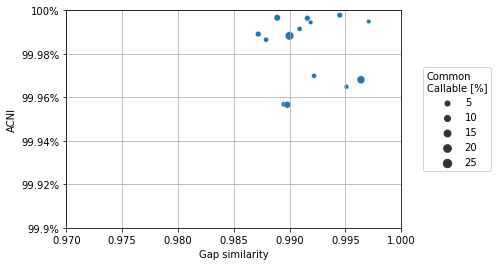

In [41]:
import seaborn

seaborn.scatterplot(x="gapJaccardSim", y="singleAgreePct", size="commonPct", data=compare_df)

plt.xlim(0.970, 1.0)
plt.xlabel("Gap similarity")

plt.ylim(99.9, 100)
plt.ylabel("ACNI")
plt.gca().yaxis.set_major_formatter("{x:g}%")

plt.grid('on')
plt.legend(title="Common\nCallable [%]", loc="center left", bbox_to_anchor=(1.05, 0.5))
